In [1]:
import pandas as pd

In [2]:
BTC_15 = pd.read_csv("data/data/ohlcv/BTCUSDT_15m_20170208_20250830.csv")
ETH_15 = pd.read_csv("data/data/ohlcv/ETHUSDT_15m_20170208_20250830.csv")
SOL_15 = pd.read_csv("data/data/ohlcv/SOLUSDT_15m_20221025_20250901.csv")

In [3]:
df = SOL_15.copy()
df = df[df["timestamp"] >= "2025-01-01"]

In [4]:
# Calculate the split index
split_idx = int(len(df) * 0.6)  # first 60% train, last 40% test

# Split into train/test
train = df.iloc[:split_idx]
test  = df.iloc[split_idx:]

split_idx = int(len(test) * 0.5)  
val  = test.iloc[:split_idx]
test  = test.iloc[split_idx:]

print("Train size:", len(train))
print("Val size:", len(val))
print("Test size:", len(test))

Train size: 14020
Val size: 4673
Test size: 4674


In [5]:
from Trading_algos.strategy_tester import StrategyTester
from Trading_algos.optimize_params import optimize, optimize_sensitivity

In [6]:
best, board = optimize(train, val_df=val, n_trials=300, seed=123)

Validating top-25: 100%|████████████████████████| 25/25 [01:17<00:00,  3.10s/trial, best_val=0.000, pf=2.13, mdd=3.06%]


In [7]:
print("Best params:", best["params"])
print("Train PF/Sharpe/MDD:",
best.get("train_profit_factor"), best.get("train_sharpe_ratio"), best.get("train_max_drawdown"))
if "score_val" in best:
    print("Val  PF/Sharpe/MDD:",
best.get("val_profit_factor"), best.get("val_sharpe_ratio"), best.get("val_max_drawdown"))
#
# # Turn leaderboard into a DataFrame to inspect the frontier
lb_df = pd.DataFrame(board)
lb_df.head()

Best params: {'timeframe': '15m', 'sensitivity': 12, 'sl_percent': 0.37, 'fixed_stop': False, 'break_even_after_tp': 1, 'risk_per_trade': 0.0047}
Train PF/Sharpe/MDD: 2.223507955971423 4.302070782970997 0.017362621441132778
Val  PF/Sharpe/MDD: 1.1362570841450943 -1.115434874376231 0.015727039402611404


,trial,params,score_train,train_total_return,train_win_rate,train_profit_factor,train_max_drawdown,train_sharpe_ratio,train_sortino_ratio,train_total_trades,...,val_margin_utilization,val_liquidation_risk,val_calmar_ratio,val_largest_win,val_largest_loss,val_volatility,val_var_95,val_position_metrics,val_order_metrics,score_combined
0,129,"{'timeframe': '15m', 'sensitivity': 12, 'sl_pe...",10.974182,0.054131,0.716216,2.223508,0.017363,4.302071,3.933008,74,...,0.0,0.0,-4.577721,64.914265,-45.002753,0.064543,-0.000355,"{'total_positions': 20, 'positions_with_partia...","{'total_orders': 61, 'entry_orders': 20, 'exit...",3.292255
1,154,"{'timeframe': '15m', 'sensitivity': 14, 'sl_pe...",8.762017,0.145449,0.557692,1.979183,0.057140,3.200755,2.979879,52,...,0.0,0.0,-14.556286,263.953029,-180.482029,0.264544,-0.001390,"{'total_positions': 18, 'positions_with_partia...","{'total_orders': 54, 'entry_orders': 18, 'exit...",2.628606
2,157,"{'timeframe': '15m', 'sensitivity': 19, 'sl_pe...",7.497863,0.057304,0.807692,2.027147,0.026837,2.504616,1.954399,52,...,0.0,0.0,18.666628,147.191322,-111.043905,0.132894,-0.000630,"{'total_positions': 16, 'positions_with_partia...","{'total_orders': 54, 'entry_orders': 16, 'exit...",2.249360
3,83,"{'timeframe': '15m', 'sensitivity': 9, 'sl_per...",6.049547,0.072598,0.640777,1.594866,0.043191,2.216522,2.073621,103,...,0.0,0.0,-0.978316,240.505263,-101.629751,0.191305,-0.001061,"{'total_positions': 29, 'positions_with_partia...","{'total_orders': 83, 'entry_orders': 29, 'exit...",1.814865
4,280,"{'timeframe': '15m', 'sensitivity': 9, 'sl_per...",4.435314,0.058153,0.531250,1.561691,0.048847,1.818960,1.801099,96,...,0.0,0.0,-0.371215,254.688585,-88.282113,0.171078,-0.000923,"{'total_positions': 28, 'positions_with_partia...","{'total_orders': 85, 'entry_orders': 28, 'exit...",1.330595


In [10]:
lb_df['params'][1]

{'timeframe': '15m',
 'sensitivity': 14,
 'sl_percent': 0.23,
 'fixed_stop': False,
 'break_even_after_tp': 0,
 'risk_per_trade': 0.018}

In [30]:
tester = StrategyTester(initial_capital=10000)
results = tester.run_backtest(
                            'FibonacciChannelStrategy',
                            val,
                            timeframe="15m",
                            sensitivity=18,
                            leverage=1.0,
                            sl_percent=1,         # 1% adjustment to fib levels
                            fixed_stop=True,       # Use fib_786 (long) / fib_236 (short)
                            break_even_after_tp=1,  # Move to breakeven after TP2 hit
                            use_take_profits=True,
                            tp1_pct=1, tp1_close=40.0,
                            tp2_pct=2, tp2_close=30.0,
                            tp3_pct=3, tp3_close=20.0,
                            tp4_pct=4, tp4_close=10.0,
                            # Risk
                            risk_per_trade=0.02,   # 1.5% risk per trade
                            verbose=True
                        )

Starting backtest for FibonacciChannelStrategy
Data period: 2025-05-27 01:00:00+00:00 to 2025-07-14 17:00:00+00:00
Data points: 4673
Generating trading signals...
Signals — long: 13 short: 13
First long idx: [560, 666, 1079] First short idx: [180, 627, 834]
Running backtest simulation...


Backtesting: 100%|██████████████████| 4673/4673 [00:02<00:00, 1593.15bars/s, Trades=25, Capital=$10,306, Position=FLAT]

Calculating performance metrics...

🎯 BACKTEST COMPLETED SUCCESSFULLY!
   Strategy: FibonacciChannelStrategy
   Total Trades: 25
   Final Return: 3.06%
   Final Capital: $10,306.39
   Win Rate: 52.00%
   Profit Factor: 1.45
   Max Drawdown: 9.45%
   Sharpe Ratio: 1.356
   Risk:Reward: 1.34
   Market Exposure: 18.11%
   Total Fees: $309.84

💡 Use display_comprehensive_metrics('FibonacciChannelStrategy') for detailed analysis


C:\Users\gulle\Documents\Trading\Trading_algos\strategy_tester.py:357: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  plot_timestamps = pd.to_datetime(data['timestamp']).dt.to_pydatetime()
C:\Users\gulle\Documents\Trading\Trading_algos\strategy_tester.py:403: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  plot_timestamps_equity = pd.to_datetime(timestamps).dt.to_pydatetime()



📊 COMPREHENSIVE METRICS TABLE FOR FIBONACCICHANNELSTRATEGY

PERFORMANCE:
--------------------------------------------------
  Total Return        : 3.06%
  Final Capital       : $10,306.39
  Total Trades        : 25
  Win Rate            : 52.00%
  Profit Factor       : 1.45
  Risk:Reward         : 1.34

RISK METRICS:
--------------------------------------------------
  Max Drawdown        : 9.45%
  Sharpe Ratio        : 1.356
  Sortino Ratio       : 0.795
  Calmar Ratio        : 5.863
  Volatility          : 40.85%
  VaR (95%)           : -0.10%

TRADE ANALYSIS:
--------------------------------------------------
  Avg Win             : $278.02
  Avg Loss            : $207.35
  Largest Win         : $416.45
  Largest Loss        : $-226.70
  Max Consec Losses   : 4
  Max Consec Wins     : 5

STRATEGY BEHAVIOR:
--------------------------------------------------
  Trades/Day          : 0.55
  Avg Hold Time       : 7.95h
  Market Exposure     : 18.11%
  Break-even          : 3.10%
  Tota

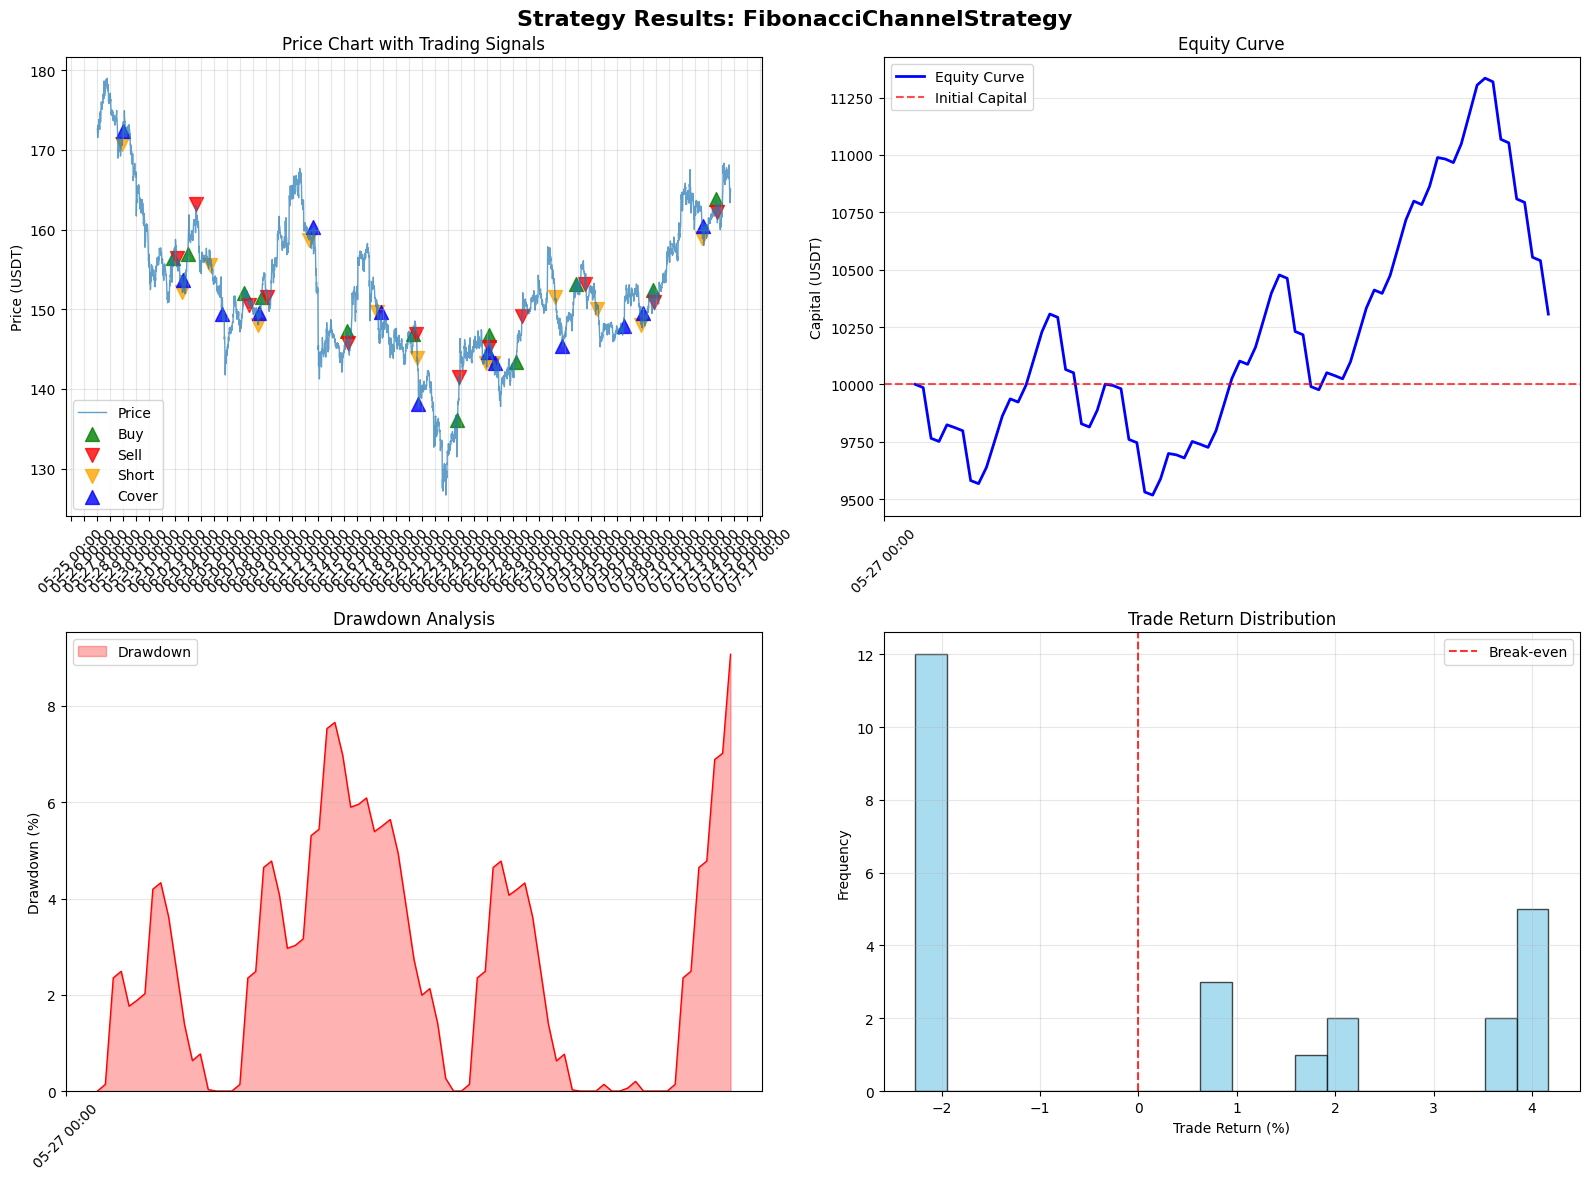

In [31]:
# Cell 4: View detailed metrics
tester.display_comprehensive_metrics('FibonacciChannelStrategy')

# Cell 5: Plot results
tester.plot_results('FibonacciChannelStrategy',show_plot=True)

In [6]:
base_params = dict(
    timeframe="15m",
    leverage=1.0,
    sl_percent=0,
    fixed_stop=False,
    break_even_after_tp=1,
    use_take_profits=True,
    tp1_pct=1, tp1_close=40.0,
    tp2_pct=2, tp2_close=30.0,
    tp3_pct=3, tp3_close=20.0,
    tp4_pct=4, tp4_close=10.0,
    risk_per_trade=0.02,     # pass through to your runner if supported
)

best, leaderboard = optimize_sensitivity(
    train_df=train,
    val_df=val,                    # or None
    base_params=base_params,
    strategy_name="FibonacciChannelStrategy",
    sens_min=4, sens_max=60,
    coarse_step=3, fine_radius=4,
    topk_val=10,                     # validate top-10 on holdout
    # scoring_fn=score_from_metrics, # optional; uses your project scorer if defined
    # runner=run_bt,                 # optional; auto-detected if you have run_bt in scope
    show_progress=True,
)

print("Best sensitivity:", int(best["sensitivity"]))
print("Best (train) PF/MDD:", best.get("train_profit_factor"), best.get("train_max_drawdown"))
if "score_val" in best:
    print("Best (val) PF/MDD:", best.get("val_profit_factor"), best.get("val_max_drawdown"))

Validating top-10: 100%|████████████████████████████████████████████| 10/10 [00:34<00:00,  3.45s/sens, score_val=0.000]

Best sensitivity: 25
Best (train) PF/MDD: 2.319047126534729 0.028487926291055083
Best (val) PF/MDD: 1.1810444631639856 0.04076846425775429


In [6]:
tester = StrategyTester(initial_capital=10000)

In [7]:
results = tester.run_backtest(
                            'FibonacciChannelStrategy',
                            train,
                            timeframe="15m",
                            sensitivity=18,
                            leverage=1.0,
                            sl_percent=0,         # 1% adjustment to fib levels
                            fixed_stop=False,       # Use fib_786 (long) / fib_236 (short)
                            break_even_after_tp=1,  # Move to breakeven after TP2 hit
                            use_take_profits=True,
                            tp1_pct=1, tp1_close=40.0,
                            tp2_pct=2, tp2_close=30.0,
                            tp3_pct=3, tp3_close=20.0,
                            tp4_pct=4, tp4_close=10.0,
                            # Risk
                            risk_per_trade=0.02,   # 1.5% risk per trade
                            verbose=True
                        )

Starting backtest for FibonacciChannelStrategy
Data period: 2025-05-03 00:00:00+00:00 to 2025-08-30 12:00:00+00:00
Data points: 11473
Generating trading signals...
Signals — long: 30 short: 31
First long idx: [381, 1024, 1277] First short idx: [186, 936, 1182]
Running backtest simulation...


Backtesting: 100%|█████████████████| 11473/11473 [00:05<00:00, 2051.61bars/s, Trades=55, Capital=$9,132, Position=FLAT]

Calculating performance metrics...

🎯 BACKTEST COMPLETED SUCCESSFULLY!
   Strategy: FibonacciChannelStrategy
   Total Trades: 55
   Final Return: -8.68%
   Final Capital: $9,131.61
   Win Rate: 76.36%
   Profit Factor: 0.91
   Max Drawdown: 16.14%
   Sharpe Ratio: -2.395
   Risk:Reward: 0.28
   Market Exposure: 16.53%
   Total Fees: $226.76

💡 Use display_comprehensive_metrics('FibonacciChannelStrategy') for detailed analysis


C:\Users\gulle\Documents\Trading\Trading_algos\strategy_tester.py:357: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  plot_timestamps = pd.to_datetime(data['timestamp']).dt.to_pydatetime()



📊 COMPREHENSIVE METRICS TABLE FOR FIBONACCICHANNELSTRATEGY

PERFORMANCE:
--------------------------------------------------
  Total Return        : -8.68%
  Final Capital       : $9,131.61
  Total Trades        : 55
  Win Rate            : 76.36%
  Profit Factor       : 0.91
  Risk:Reward         : 0.28

RISK METRICS:
--------------------------------------------------
  Max Drawdown        : 16.14%
  Sharpe Ratio        : -2.395
  Sortino Ratio       : -1.096
  Calmar Ratio        : -3.410
  Volatility          : 22.98%
  VaR (95%)           : -0.05%

TRADE ANALYSIS:
--------------------------------------------------
  Avg Win             : $60.80
  Avg Loss            : $216.59
  Largest Win         : $250.15
  Largest Loss        : $-495.28
  Max Consec Losses   : 2
  Max Consec Wins     : 15

STRATEGY BEHAVIOR:
--------------------------------------------------
  Trades/Day          : 0.47
  Avg Hold Time       : 8.35h
  Market Exposure     : 16.53%
  Break-even          : 2.27%
  

C:\Users\gulle\Documents\Trading\Trading_algos\strategy_tester.py:403: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  plot_timestamps_equity = pd.to_datetime(timestamps).dt.to_pydatetime()


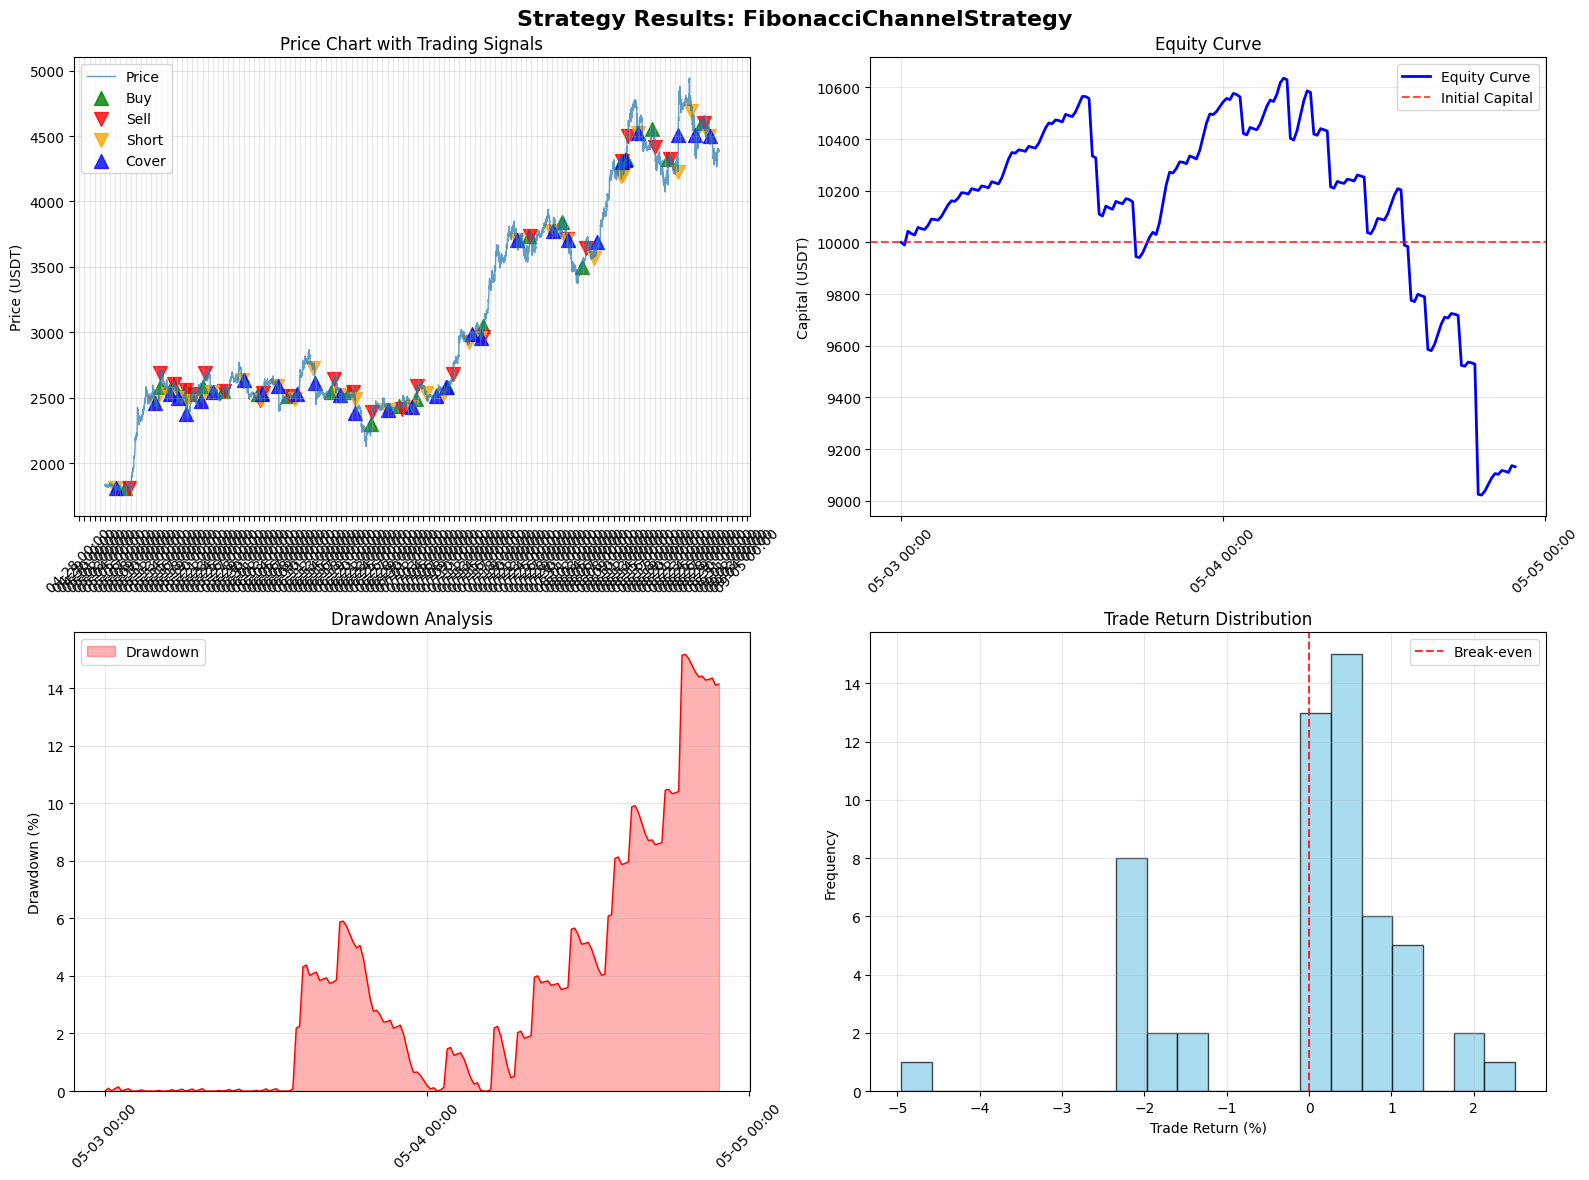

In [8]:
# Cell 4: View detailed metrics
tester.display_comprehensive_metrics('FibonacciChannelStrategy')

# Cell 5: Plot results
tester.plot_results('FibonacciChannelStrategy',show_plot=True)